BRASIL É UM PAÍS DE DIMENSÕES CONTINENTAIS E AMPLAS DESIGUALDADES REGIONAIS

In [154]:
# Silent Warnings
import warnings
warnings.filterwarnings('ignore')

In [155]:
# Importing libraries
import pandas as pd
#from google.colab import drive
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from datetime import datetime
import seaborn as sns
import numpy as np
import duckdb
import my_functions as mf

In [156]:
pd.set_option('display.max_columns', None)

In [157]:
# import locale

# # Set the Brazilian locale
# locale.setlocale(locale.LC_NUMERIC, 'pt_BR.UTF-8')

# 1. Data Transformation, Exploration, and Analysis

# Database

    The dataset contains socio-demographic and firmographic features for 530 cities over a period of 7 months.
___

In [174]:
# Organizing key information within each dataset

chs = pd.read_csv('data/chs.csv')
chs.columns = chs.columns.str.lower()
chs["uf"] = chs['cidade-uf'].str[-2:]
chs["cidade-uf"] = chs['cidade-uf'].str[:-3]
chs["chs"] = chs['chs'].str[:-1]
chs["chs"] = chs["chs"].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
chs.rename(columns={'cidade-uf': 'cidade', 'mes/ano':'mes_ano'}, inplace=True)

churn = pd.read_csv('data/churn.csv')
churn.columns = churn.columns.str.lower()
churn["churn"] = churn['churn'].str[:-1]
churn["churn"] = churn["churn"].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
churn.rename(columns={'mes/ano':'mes_ano'}, inplace=True)

mub = pd.read_csv('data/mub2.csv', sep=';')
mub.columns = mub.columns.str.lower()
mub.rename(columns={'mes/ano':'mes_ano',
                    'Cidade':'cidade'}, inplace=True)

pedidos = pd.read_csv('data/pedidos.csv')
pedidos.columns = pedidos.columns.str.lower()
pedidos["pedidos"] = pedidos["pedidos"].str.replace('.', '')
pedidos['pedidos'] = pd.to_numeric(pedidos['pedidos'], errors='coerce')
pedidos.rename(columns={'mes/ano':'mes_ano'}, inplace=True)

reativacao = pd.read_csv('data/reativacao.csv')
reativacao.columns = reativacao.columns.str.lower()
reativacao["reativacao"] = reativacao['reativacao'].str[:-1]
reativacao["reativacao"] = reativacao["reativacao"].str.replace('[A-Za-z]', '').str.replace(',', '.').astype(float)
reativacao.rename(columns={'mes/ano':'mes_ano'}, inplace=True)

restaurantes = pd.read_csv('data/restaurantes.csv')
restaurantes.columns = restaurantes.columns.str.lower()
restaurantes["uf"] = restaurantes['cidade-uf'].str[-2:]
restaurantes["cidade-uf"] = restaurantes['cidade-uf'].str[:-3]
restaurantes.rename(columns={'cidade-uf': 'cidade', 'mes/ano':'mes_ano'}, inplace=True)

sociodemografica = pd.read_csv('data/sociodemografica2.csv', sep=";")
sociodemografica.columns = sociodemografica.columns.str.lower()
sociodemografica["uf"] = sociodemografica['cidade'].str[-2:]
sociodemografica["cidade"] = sociodemografica['cidade'].str[:-3]


In [101]:
df = \
duckdb.query("select a.*,\
                     b.churn,\
                     c.mub,\
                     d.pedidos,\
                     e.reativacao,\
                     f.restaurantes,\
                     g.renda_media,\
                     g.populacao,\
                     g.leads_total\
                from chs a\
           left join churn b\
                  on a.uf = b.uf and a.mes_ano = b.mes_ano and a.cidade = b.cidade\
           left join mub c\
                  on a.uf = c.uf and a.mes_ano = c.mes_ano and a.cidade = c.cidade\
           left join pedidos d\
                  on a.uf = d.uf and a.mes_ano = d.mes_ano and a.cidade = d.cidade\
           left join reativacao e\
                  on a.uf = e.uf and a.mes_ano = e.mes_ano and a.cidade = e.cidade\
           left join restaurantes f\
                  on a.uf = f.uf and a.mes_ano = f.mes_ano and a.cidade = f.cidade\
           left join sociodemografica g\
                  on a.uf = g.uf and a.cidade = g.cidade").to_df()

In [102]:
# # Convert to datetime and format as yyyy-mm-dd
# df['mes_ano'] = pd.to_datetime(df['mes_ano'], format='%d/%m/%Y').dt.strftime('%Y-%m-%d')

In [103]:
# Convert to datetime and format as yyyy-mm
df['mes_ano'] = pd.to_datetime(df['mes_ano'], format='%d/%m/%Y').dt.to_period('M').astype(str)

    Creating a Region Variable

In [104]:
# Mapping of 'uf' to regions
uf_to_region = {
    # North
    'AC': 'NORTE', 'AP': 'NORTE', 'AM': 'NORTE', 'PA': 'NORTE', 'RO': 'NORTE', 'RR': 'NORTE', 'TO': 'NORTE',
    # Northeast
    'AL': 'NORDESTE', 'BA': 'NORDESTE', 'CE': 'NORDESTE', 'MA': 'NORDESTE', 'PB': 'NORDESTE', 'PE': 'NORDESTE', 'PI': 'NORDESTE', 'RN': 'NORDESTE', 'SE': 'NORDESTE',
    # Southeast
    'ES': 'SUDESTE', 'MG': 'SUDESTE', 'RJ': 'SUDESTE', 'SP': 'SUDESTE',
    # South
    'PR': 'SUL', 'RS': 'SUL', 'SC': 'SUL',
    # Central-West
    'DF': 'CENTRO-OESTE', 'GO': 'CENTRO-OESTE', 'MT': 'CENTRO-OESTE', 'MS': 'CENTRO-OESTE'
}

# Add region column
df['region'] = df['uf'].map(uf_to_region)


In [105]:
# Restaurantes ativos
df['cobertura_delivery'] = round((df['mub'] / df['populacao'])*100,1)

In [106]:
df.head()

,cidade,mes_ano,chs,uf,churn,mub,pedidos,reativacao,restaurantes,renda_media,populacao,leads_total,region,cobertura_delivery
0,SAO PAULO,2022-06,78.6,SP,8.77,726371,1801291,3.51,9564,1807,10481993,359982,SUDESTE,6.9
1,SALVADOR,2022-06,51.2,BA,13.43,100580,342563,5.45,2699,1238,2529737,92439,NORDESTE,4.0
2,BRASILIA,2022-06,55.7,DF,8.14,262343,1305636,3.51,6291,2281,2492110,93774,CENTRO-OESTE,10.5
3,FORTALEZA,2022-06,65.2,CE,11.69,111628,266549,4.05,1520,1168,2436398,74509,NORDESTE,4.6
4,BELO HORIZONTE,2022-06,86.0,MG,7.37,195980,696533,4.34,3493,1867,2330398,69402,SUDESTE,8.4


# Passo 1

> Qual é o número de restaurantes (absoluto) que foram reativados por mês?

To calculate the number of reactivated restaurants (RR), we can just multiply restaurante x reativacao

$$ RR = \ \text{restaurante} \cdot \text{reativacao} \ $$

In [107]:
# Restaurantes ativos
df['restaurantes_reativados'] = (df['restaurantes'] * df['reativacao']/100).astype(int)
# Taxa de churn e reativação já estão no dfset


In [108]:
rr = df.groupby('mes_ano')['restaurantes_reativados'].agg('sum')

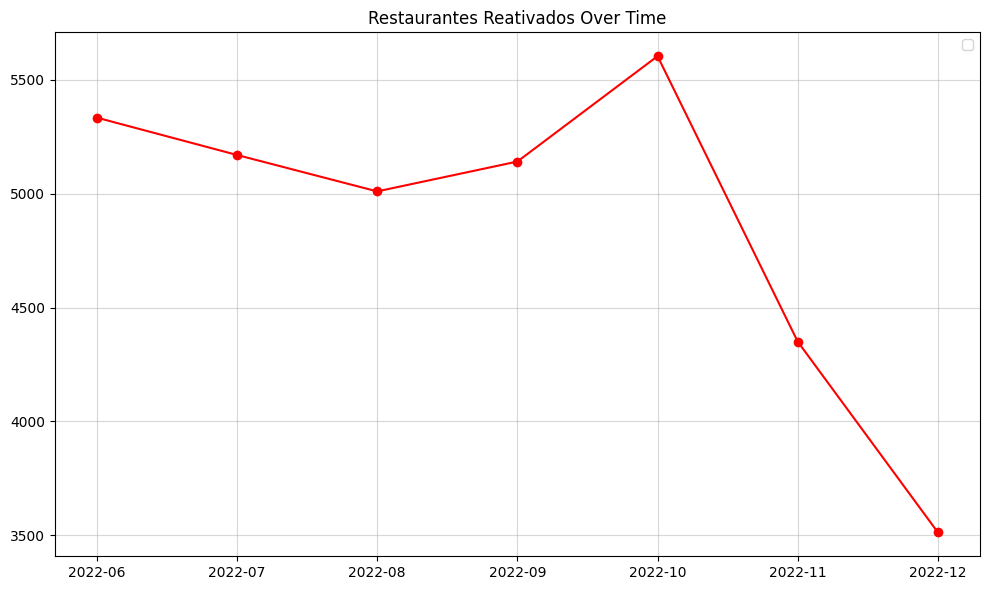

In [109]:
# Plot the red line chart
plt.figure(figsize=(10, 6))
plt.plot(rr.index, rr.values, color='red', marker='o', linestyle='-')
plt.title('Restaurantes Reativados Over Time')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=0)
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

In [110]:
rr_region = df.groupby(['mes_ano', 'region'])['restaurantes_reativados'].agg('sum')

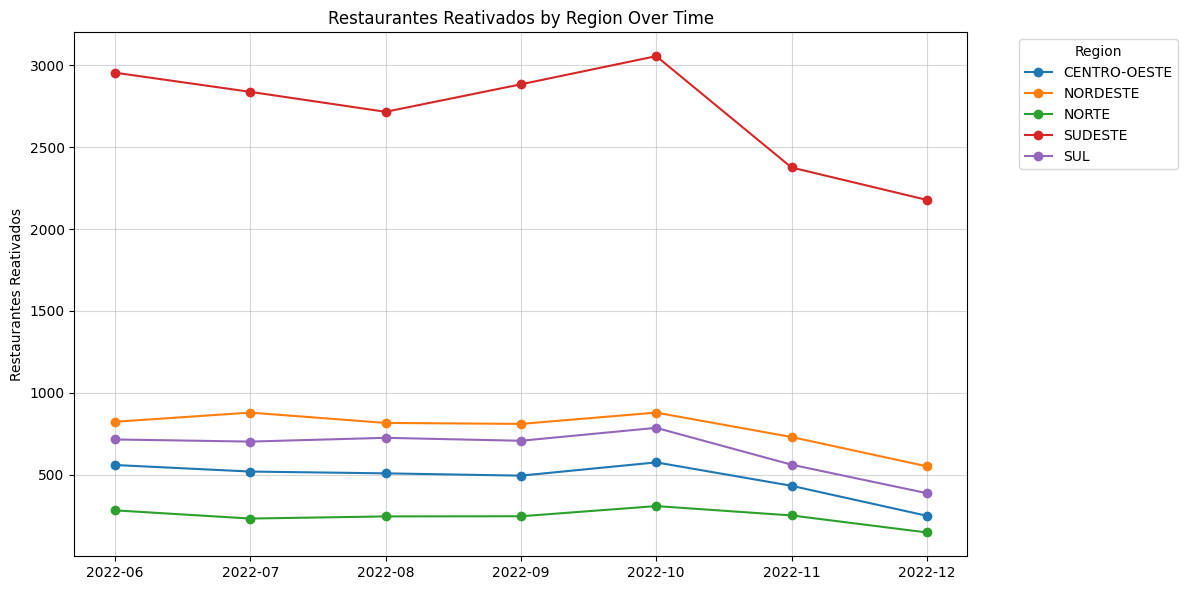

In [111]:
import matplotlib.pyplot as plt

# Group and aggregate the data
rr_region = df.groupby(['mes_ano', 'region'])['restaurantes_reativados'].agg('sum').reset_index()

# Pivot the data to have regions as columns for easier plotting
pivot_data = rr_region.pivot(index='mes_ano', columns='region', values='restaurantes_reativados')

# Plot the line chart for each region
plt.figure(figsize=(12, 6))
for region in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[region], marker='o', label=region)

# Add titles and labels
plt.title('Restaurantes Reativados by Region Over Time')
plt.xlabel('')
plt.ylabel('Restaurantes Reativados')
plt.xticks(rotation=0)
plt.grid(alpha=0.5)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot
plt.tight_layout()
plt.show()


> Qual é o número de restaurantes (absoluto) que deram churn por mês?

To calculate the number of Restaurantes Sem Pedido (RSP), we need the % of resturants in churn and the number of Restaurantes Com Pedido (RCP)

$$ RSP = \frac{RCP \cdot \text{churn}}{1 - \text{churn}} $$

In [112]:
# Restaurantes que deram churn
df['restaurantes_churn'] = ((df['restaurantes'] * df['churn']/100)/(1-df['churn']/100)).astype(int)


In [113]:
rsp = df.groupby('mes_ano')['restaurantes_churn'].agg('sum')

In [114]:
df.columns

Index(['cidade', 'mes_ano', 'chs', 'uf', 'churn', 'mub', 'pedidos',
       'reativacao', 'restaurantes', 'renda_media', 'populacao', 'leads_total',
       'region', 'cobertura_delivery', 'restaurantes_reativados',
       'restaurantes_churn'],
      dtype='object')

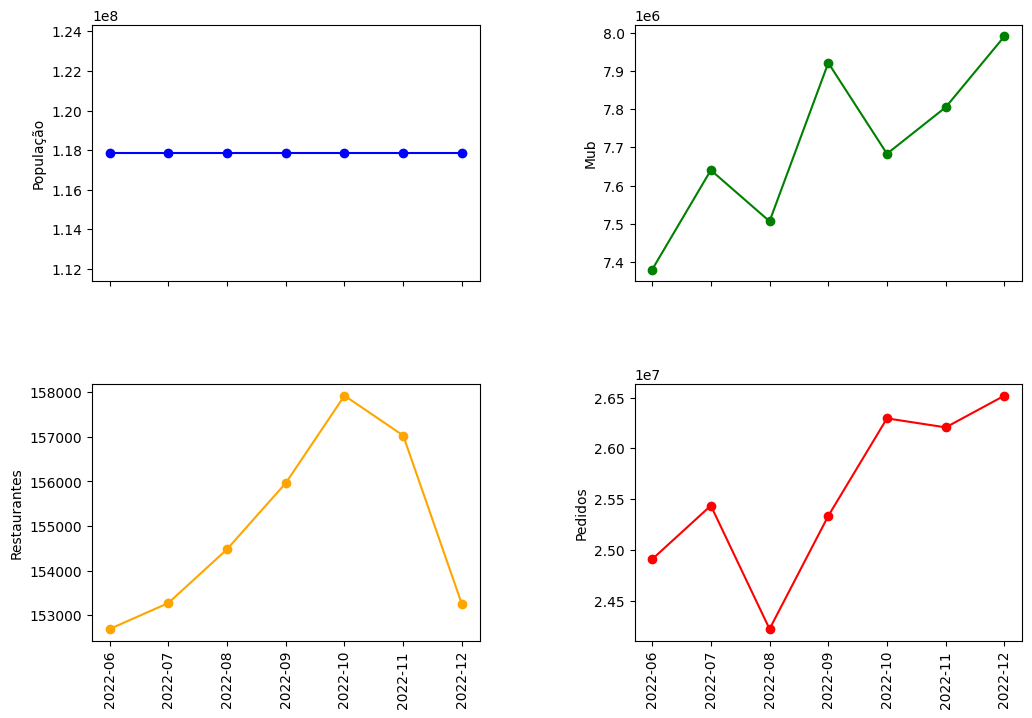

In [115]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec

# Grouped data
populacao_agg = df.groupby('mes_ano')['populacao'].agg('sum')
mub_agg = df.groupby('mes_ano')['mub'].agg('sum')
restaurantes_agg = df.groupby('mes_ano')['restaurantes'].agg('sum')
pedidos_agg = df.groupby('mes_ano')['pedidos'].agg('sum')

# Create figure and GridSpec layout
fig = plt.figure(figsize=(12, 8))
gs = GridSpec(2, 2, wspace=0.4, hspace=0.4)

# Plot "população" in the top-left
ax1 = fig.add_subplot(gs[0, 0])
ax1.plot(populacao_agg.index, populacao_agg.values, color='blue', marker='o', linestyle='-')
ax1.set_title('')
ax1.set_xlabel('')
ax1.set_ylabel('População')
ax1.tick_params(axis='x', rotation=45)
ax1.set_xticklabels([])

# Plot "mub_agg" in the top-right
ax2 = fig.add_subplot(gs[0, 1])
ax2.plot(mub_agg.index, mub_agg.values, color='green', marker='o', linestyle='-')
ax2.set_title('')
ax2.set_xlabel('')
ax2.set_ylabel('Mub')
ax2.tick_params(axis='x', rotation=45)
ax2.set_xticklabels([])

# Plot "restaurantes_agg" in the bottom-left
ax3 = fig.add_subplot(gs[1, 0])
ax3.plot(restaurantes_agg.index, restaurantes_agg.values, color='orange', marker='o', linestyle='-')
ax3.set_title('')
ax3.set_xlabel('')
ax3.set_ylabel('Restaurantes')
ax3.tick_params(axis='x', rotation=90)

# Plot "pedidos_agg" in the bottom-right
ax4 = fig.add_subplot(gs[1, 1])
ax4.plot(pedidos_agg.index, pedidos_agg.values, color='red', marker='o', linestyle='-')
ax4.set_title('')
ax4.set_xlabel('')
ax4.set_ylabel('Pedidos')
ax4.tick_params(axis='x', rotation=90)

# Adjust layout
plt.tight_layout()
plt.show()


In [116]:
# import pandas as pd

# # Grouped data converted to DataFrames
populacao_agg = df.groupby('mes_ano')['populacao'].agg('sum').reset_index()
mub_agg = df.groupby('mes_ano')['mub'].agg('sum').reset_index()
restaurantes_agg = df.groupby('mes_ano')['restaurantes'].agg('sum').reset_index()
leads_total_agg = df.groupby('mes_ano')['leads_total'].agg('sum').reset_index()
pedidos_agg = df.groupby('mes_ano')['pedidos'].agg('sum').reset_index()

# # Perform left joins step by step
result = populacao_agg.merge(mub_agg, on='mes_ano', how='left')
result = result.merge(restaurantes_agg, on='mes_ano', how='left')
result = result.merge(leads_total_agg, on='mes_ano', how='left')
result = result.merge(pedidos_agg, on='mes_ano', how='left')

# # Display the resulting DataFrame
result


,mes_ano,populacao,mub,restaurantes,leads_total,pedidos
0,2022-06,117860086,7379999,152692,18654900,24907734
1,2022-07,117860086,7640321,153274,18654900,25436094
2,2022-08,117860086,7506525,154481,18654900,24220605
3,2022-09,117860086,7920924,155965,18654900,25334610
4,2022-10,117860086,7683129,157925,18654900,26295980
5,2022-11,117860086,7804866,157031,18654900,26206926
6,2022-12,117860086,7990388,153248,18654900,26519684


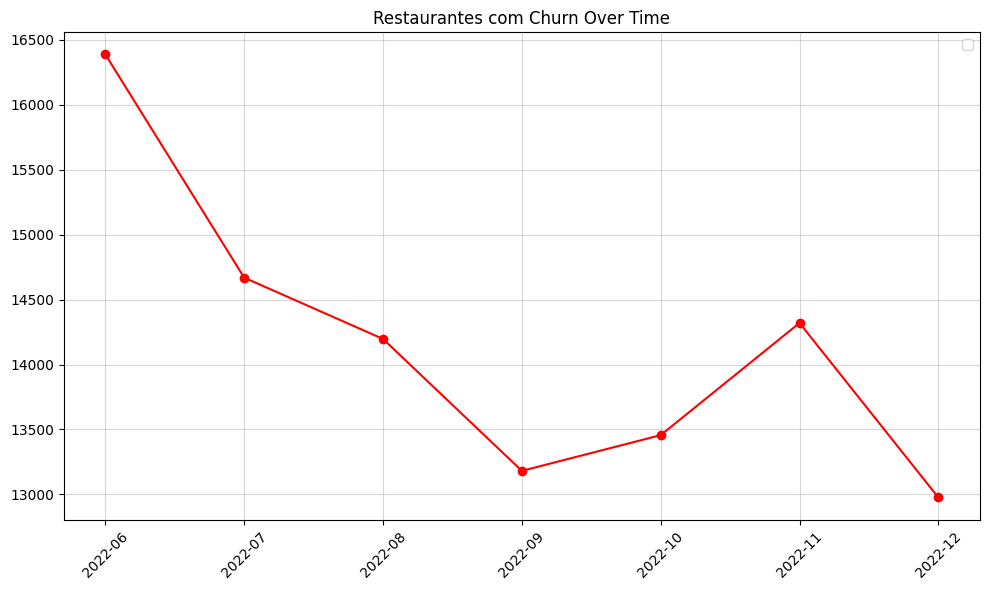

In [117]:
# Plot the red line chart
plt.figure(figsize=(10, 6))
plt.plot(rsp.index, rsp.values, color='red', marker='o', linestyle='-')
plt.title('Restaurantes com Churn Over Time')
plt.xlabel('')
plt.ylabel('')
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.legend()
plt.tight_layout()
plt.show()

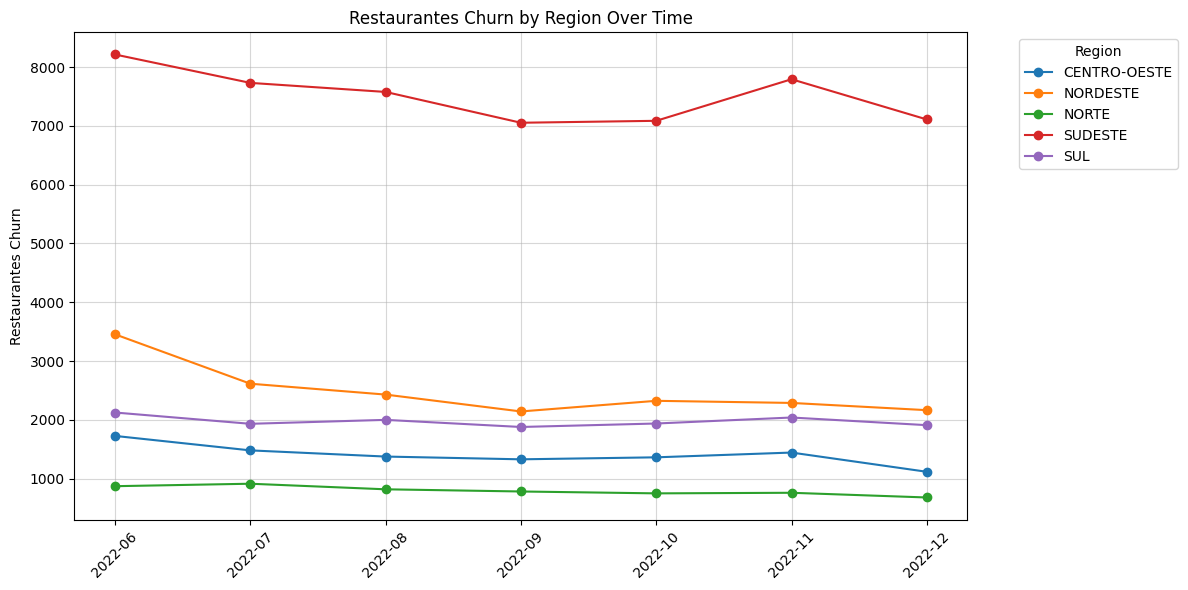

In [118]:
import matplotlib.pyplot as plt

# Group and aggregate the data
rsp_region = df.groupby(['mes_ano', 'region'])['restaurantes_churn'].agg('sum').reset_index()

# Pivot the data to have regions as columns for easier plotting
pivot_data = rsp_region.pivot(index='mes_ano', columns='region', values='restaurantes_churn')

# Plot the line chart for each region
plt.figure(figsize=(12, 6))
for region in pivot_data.columns:
    plt.plot(pivot_data.index, pivot_data[region], marker='o', label=region)

# Add titles and labels
plt.title('Restaurantes Churn by Region Over Time')
plt.xlabel('')
plt.ylabel('Restaurantes Churn')
plt.xticks(rotation=45)
plt.grid(alpha=0.5)
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')  # Legend outside the plot
plt.tight_layout()
plt.show()


> Qual é o número de restaurantes ativos por mês?


In [119]:
df.groupby('mes_ano')['restaurantes'].agg('sum')

mes_ano
2022-06    152692
2022-07    153274
2022-08    154481
2022-09    155965
2022-10    157925
2022-11    157031
2022-12    153248
Name: restaurantes, dtype: int64

> Qual é a média de mub no primeiro quartil? 

In [120]:
# Calculate the first quartile limit
q1 = df['mub'].quantile(0.25)

# Filter data to include only values on first quartile
mub_q1 = df[df['mub'] <= q1]

# Calculate the average of mub for the first quartile limit
media_mub_q1 = round(mub_q1['mub'].mean())

print(f"Média de MUB no primeiro quartil: {media_mub_q1}")

Média de MUB no primeiro quartil: 811


> Qual é a média de pedidos no terceiro quartil do mub?

In [121]:
# Calculate the third quartile limit
q3 = df['mub'].quantile(0.75)

# Filter data to include only values on first quartile
mub_q1 = df[df['mub'] > q3]

# Calculate the average of pedidos for the third quartile of mub
media_mub_q1 = round(mub_q1['pedidos'].mean())

print(f"Média de pedidos no terceiro quartil do mub: {media_mub_q1}")

Média de pedidos no terceiro quartil do mub: 164265


# Passo 2

> Existe alguma correlação entre pedidos e número de restaurantes?

In [122]:
# Calcular a correlação entre pedidos e número de restaurantes
correlacao = df['pedidos'].corr(df['restaurantes'])

print(f"Correlação entre pedidos e número de restaurantes: {correlacao}")

Correlação entre pedidos e número de restaurantes: 0.9924591801362665


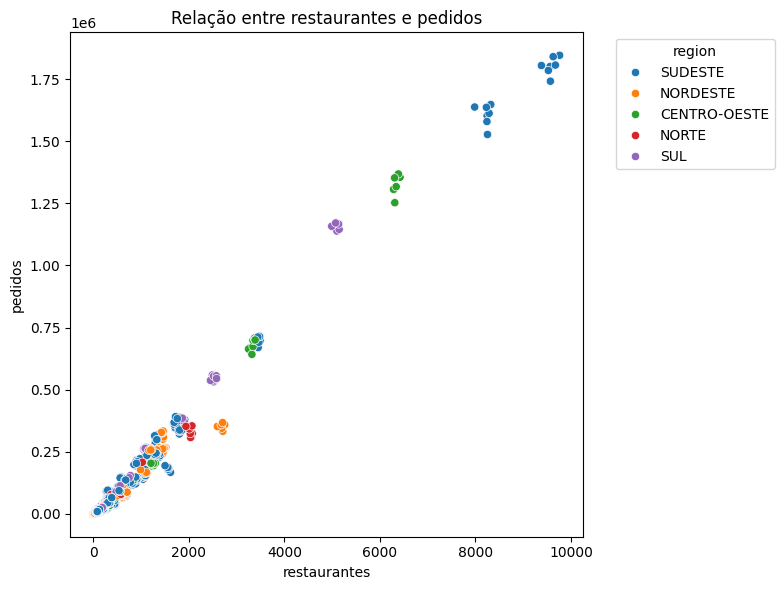

In [123]:
mf.plot_scatter(data=df, x='restaurantes', y='pedidos', hue="region")

There is a strong correlation between Número de Restaurantes e Total de Pedidos
___

> Existe alguma correlação entre a renda média da região e o mub?

In [124]:
# Calcular a correlação entre pedidos e número de restaurantes
correlacao = df['mub'].corr(df['renda_media'])

print(f"Correlação entre pedidos e número de restaurantes: {correlacao}")

Correlação entre pedidos e número de restaurantes: 0.384768227949471


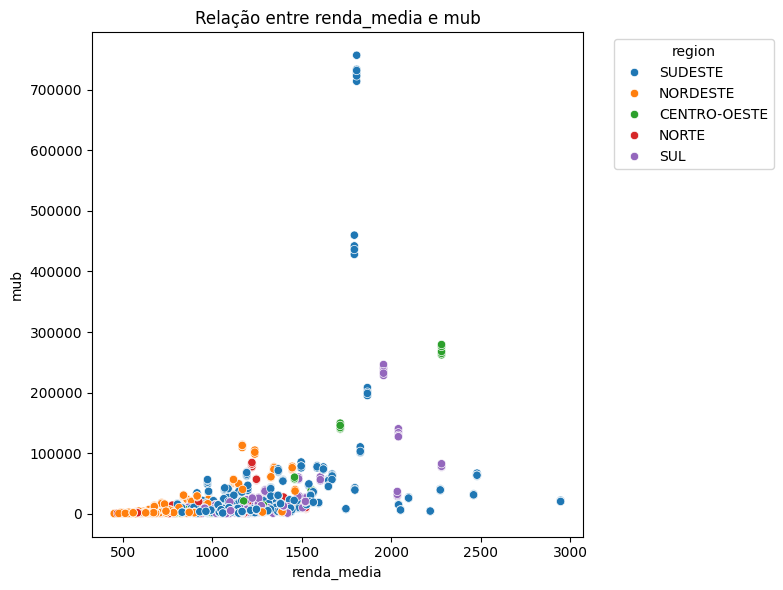

In [125]:
mf.plot_scatter(data=df, x='renda_media', y='mub', hue="region")

There is a conglomerate of cities of SUDESTE and SUL, with medium-high income but with a very low mub (population with at least one order in the delivery platform)
___

There is some negative correlation between renda média and mub.
___

# Passo 3

In [126]:
# mf.plot_scatter(df, x='restaurantes_reativados', y='mub', hue='region')

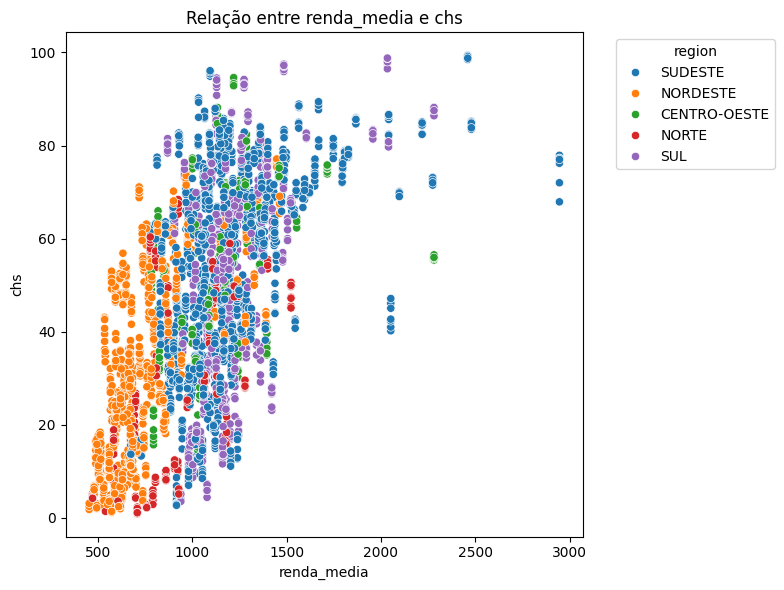

In [127]:
mf.plot_scatter(df, x='renda_media', y='chs', hue='region')

There are some cities in the South (SUL) and Southeast (SUDESTE) regions that have twice the income of cities in the Northeast (NORDESTE), yet they have the same coverage as the latter.
___

Poins with covering above 50% are mostly represented by medium low income.
___
There is no evidence of problems related to low coverage in counties with high income. The points in right-down quarter are likely to be outliers.
___

    Renda Média x Pedidos

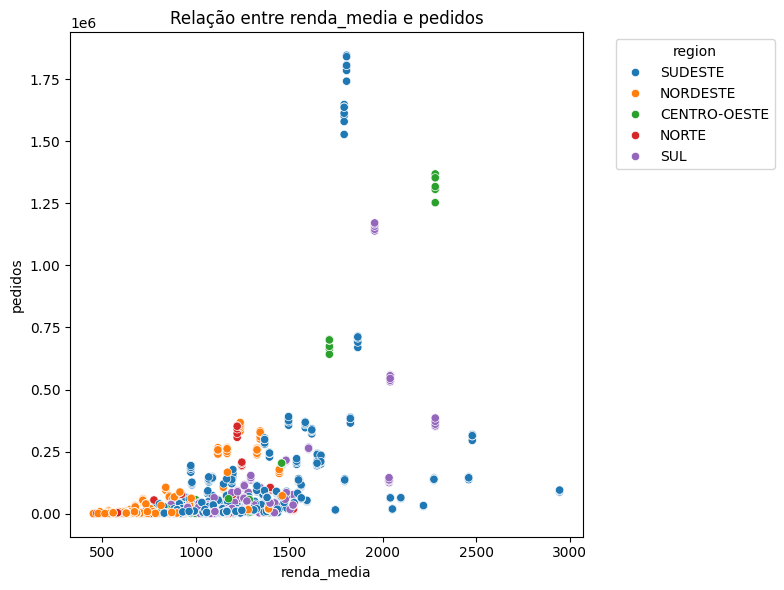

In [128]:
mf.plot_scatter(data=df, x='renda_media', y='pedidos', hue='region')

    % de Restaurantes ativos para comparar com CHS

In [129]:
df['restaurantes_ativos'] = round((df['restaurantes'] + df['restaurantes_churn'])/df['leads_total']*100, 1)

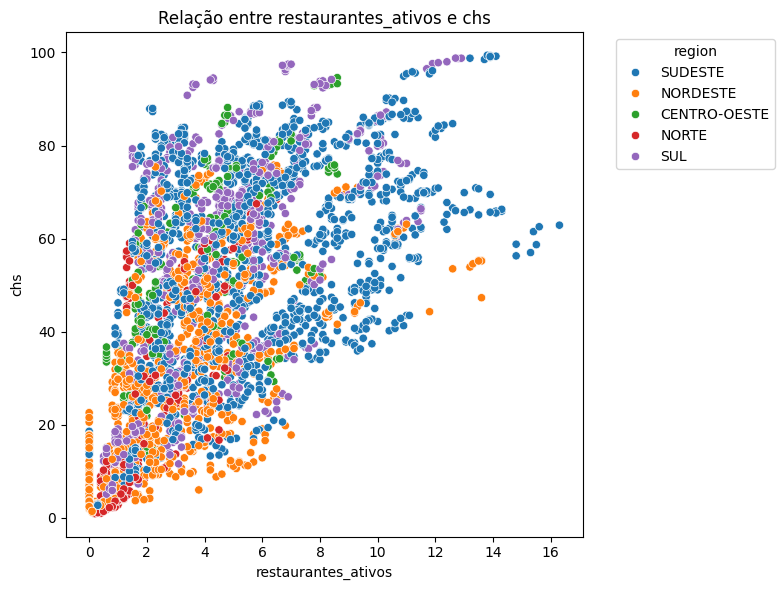

In [130]:
mf.plot_scatter(data=df, x='restaurantes_ativos', y='chs', hue='region')

The higher the rate of active restaurants (restaurantes_ativos), the higher the percentage of the population covered (chs)
___

    Mean or Median?

We'll use median because we have some extreme values that could polute our mean.

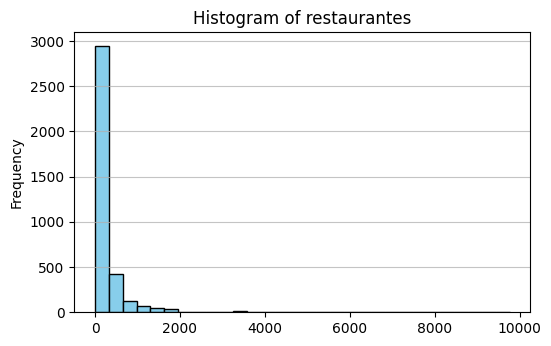

In [131]:
mf.plot_hist(df, 'restaurantes')

In [132]:
mf.check_outliers(df)

,count,mean,std,min,25%,50%,75%,max,IQR,BotOutlier,TopOutlier,CheckBotOut,CheckTopOut
chs,3710.0,47.0,24.2,0.9,28.0,48.5,67.2,99.4,39.2,-30.80,126.00,No,No
churn,3710.0,9.7,5.5,0.0,6.8,8.7,11.2,90.0,4.4,0.20,17.80,Yes,Yes
mub,3710.0,14535.4,43888.8,29.0,1667.2,4575.0,12201.8,757117.0,10534.6,-14134.70,28003.70,No,Yes
pedidos,3710.0,48226.9,147852.6,30.0,3324.5,10681.5,35544.8,1846316.0,32220.3,-45005.95,83875.25,No,Yes
reativacao,3710.0,3.2,2.4,0.0,1.9,3.0,4.2,50.0,2.3,-1.55,7.65,No,Yes
restaurantes,3710.0,292.3,743.7,2.0,46.0,100.0,256.0,9762.0,210.0,-269.00,571.00,No,Yes
renda_media,3710.0,1077.7,339.3,453.0,850.0,1080.0,1249.0,2946.0,399.0,251.50,1847.50,No,Yes
populacao,3710.0,222377.5,585456.6,50071.0,69407.0,101415.5,196935.0,10481993.0,127528.0,-121885.00,388227.00,No,Yes
leads_total,3710.0,35197.9,151154.2,0.0,1868.0,3019.5,6658.0,996000.0,4790.0,-5317.00,13843.00,No,Yes
cobertura_delivery,3710.0,5.0,3.8,0.0,2.2,4.3,6.9,36.7,4.7,-4.85,13.95,No,Yes


In [133]:
# Replace infinite values with NaN to make filtering easier
df.replace([np.inf, -np.inf], np.nan, inplace=True)

# Drop rows with NaN (which now includes rows with inf or -inf)
df = df.dropna()

We removed one city from the dataset because it contained inf values in the restaurantes_ativos variable.

In [134]:
mf.check_outliers(df)

,count,mean,std,min,25%,50%,75%,max,IQR,BotOutlier,TopOutlier,CheckBotOut,CheckTopOut
chs,3703.0,47.1,24.1,0.9,28.1,48.6,67.3,99.4,39.2,-30.70,126.10,No,No
churn,3703.0,9.7,5.5,0.0,6.8,8.7,11.2,90.0,4.4,0.20,17.80,Yes,Yes
mub,3703.0,14562.2,43925.9,29.0,1675.5,4593.0,12219.0,757117.0,10543.5,-14139.75,28034.25,No,Yes
pedidos,3703.0,48317.6,147977.6,30.0,3349.0,10700.0,35638.5,1846316.0,32289.5,-45085.25,84072.75,No,Yes
reativacao,3703.0,3.3,2.4,0.0,1.9,3.0,4.2,50.0,2.3,-1.55,7.65,No,Yes
restaurantes,3703.0,292.9,744.3,2.0,46.0,100.0,257.0,9762.0,211.0,-270.50,573.50,No,Yes
renda_media,3703.0,1078.4,339.2,453.0,857.0,1081.0,1249.0,2946.0,392.0,269.00,1837.00,No,Yes
populacao,3703.0,222698.3,585963.3,50071.0,69434.0,101511.0,196935.0,10481993.0,127501.0,-121817.50,388186.50,No,Yes
leads_total,3703.0,35264.5,151289.3,1012.0,1870.0,3024.0,6658.0,996000.0,4788.0,-5312.00,13840.00,No,Yes
cobertura_delivery,3703.0,5.0,3.8,0.0,2.2,4.3,6.9,36.7,4.7,-4.85,13.95,No,Yes


    Calculating median and rerunnning the describe table

In [135]:
df_median = df.loc[:, df.columns != 'mes_ano'].groupby(['cidade','uf','region']).agg('median').reset_index()

In [136]:
mf.check_outliers(df_median)

,count,mean,std,min,25%,50%,75%,max,IQR,BotOutlier,TopOutlier,CheckBotOut,CheckTopOut
chs,529.0,47.2,24.2,1.2,28.7,48.8,67.3,99.1,38.6,-29.20,125.20,No,No
churn,529.0,9.3,3.0,0.0,7.3,8.8,10.6,24.1,3.3,2.35,15.55,Yes,Yes
mub,529.0,14554.8,43762.7,46.0,1708.0,4666.0,12140.0,726914.0,10432.0,-13940.00,27788.00,No,Yes
pedidos,529.0,48399.7,148227.3,55.0,3449.0,10682.0,36012.0,1805036.0,32563.0,-45395.50,84856.50,No,Yes
reativacao,529.0,3.0,1.5,0.0,2.2,3.0,3.8,16.7,1.6,-0.20,6.20,No,Yes
restaurantes,529.0,293.2,744.6,2.0,46.0,102.0,256.0,9569.0,210.0,-269.00,571.00,No,Yes
renda_media,529.0,1078.4,339.5,453.0,857.0,1081.0,1249.0,2946.0,392.0,269.00,1837.00,No,Yes
populacao,529.0,222698.3,586438.7,50071.0,69434.0,101511.0,196935.0,10481993.0,127501.0,-121817.50,388186.50,No,Yes
leads_total,529.0,35264.5,151412.0,1012.0,1870.0,3024.0,6658.0,996000.0,4788.0,-5312.00,13840.00,No,Yes
cobertura_delivery,529.0,5.0,3.7,0.1,2.3,4.2,6.7,30.8,4.4,-4.30,13.30,No,Yes


It seems that we have the presence of upper outliers. However, since we have a significant number of cities, each with very distinct demographic characteristics, these outliers might not be considered true outliers if analyzed exclusively within the context of each individual city.
___

In [137]:
df[df['cobertura_delivery']==df.cobertura_delivery.max()]

,cidade,mes_ano,chs,uf,churn,mub,pedidos,reativacao,restaurantes,renda_media,populacao,leads_total,region,cobertura_delivery,restaurantes_reativados,restaurantes_churn,restaurantes_ativos
3000,BALNEARIO CAMBORIU,2022-12,98.79,SC,5.33,36711,145114,0.93,750,2034,100154,6246,SUL,36.7,6,42,12.7


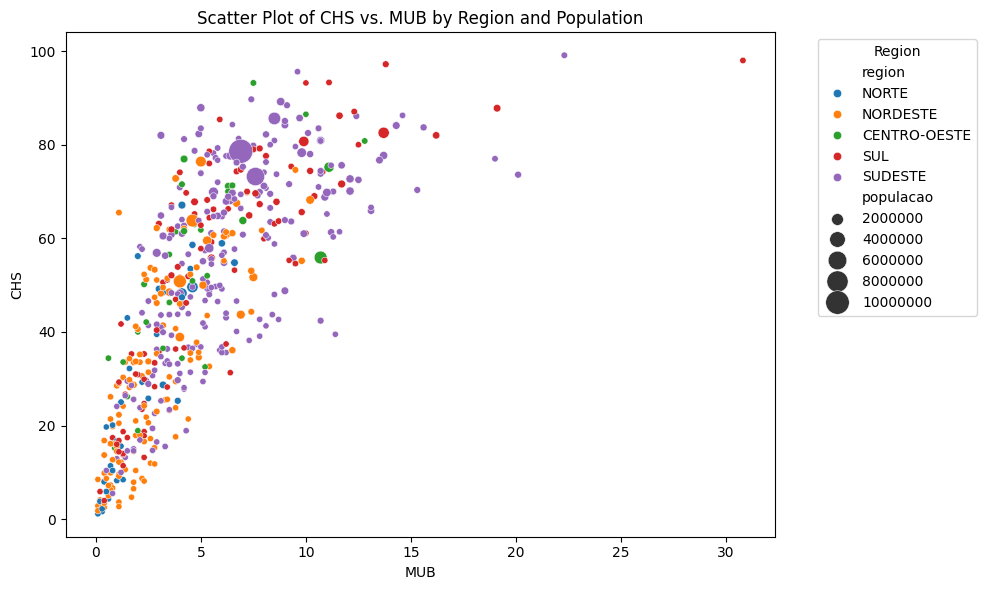

In [138]:
import matplotlib.pyplot as plt
import seaborn as sns

# Scatter plot with hue and size
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df_median, 
    x='cobertura_delivery', 
    y='chs', 
    hue='region',  # Color by region
    size='populacao',  # Size of points by populacao
    sizes=(20, 300),  # Adjust the size range of points
    palette='tab10'  # Optional color palette
)

# Customize the plot
plt.title('Scatter Plot of CHS vs. MUB by Region and Population')
plt.xlabel('MUB')
plt.ylabel('CHS')
plt.legend(title='Region', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()

plt.show()


In [139]:
import plotly.express as px

# Example DataFrame
# Replace this with your `df_median`

# Create interactive scatter plot
fig = px.scatter(
    df_median,
    x='cobertura_delivery',
    y='chs',
    color='region',
    size='populacao',
    hover_data={
        'mub': True,
        'chs': True,
        'region': True,
        'populacao': True,
        'uf':True,
        'cidade':True
    },
    title='Interactive Scatter Plot: CHS vs MUB by Region and Population'
)

# Show the plot
fig.show()


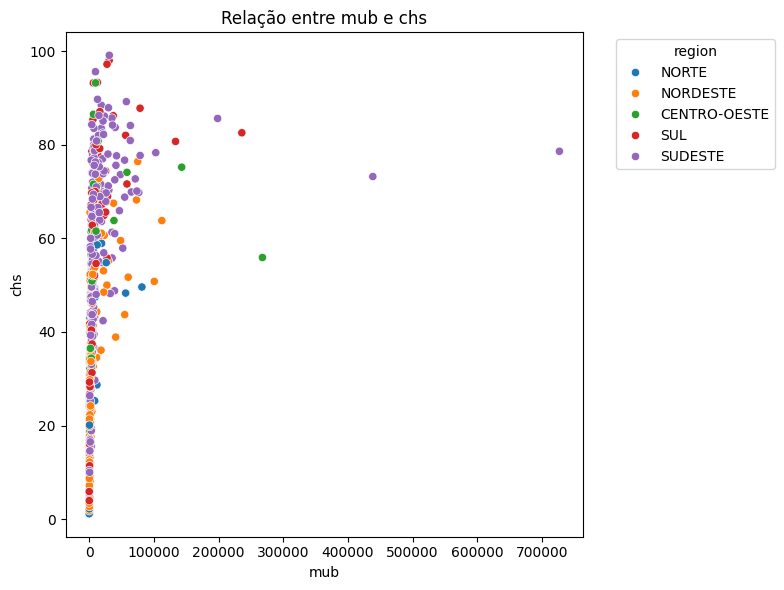

In [140]:
mf.plot_scatter(df_median, x='mub', y='chs', hue='region')

> Passo 3: Criação de uma segmentação

In [141]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA

# Select relevant features for clustering (exclude categorical and identifier variables)
features = df_median[['chs', 'churn', 'mub', 'pedidos', 'reativacao', 'restaurantes', 
                      'renda_media', 'populacao', 'leads_total', 'restaurantes_reativados', 
                      'restaurantes_churn', 'restaurantes_ativos']]

# Handle missing or infinite values
features.replace([np.inf, -np.inf], np.nan, inplace=True)
features.dropna(inplace=True)

# Standardize the data
scaler = StandardScaler()
features_scaled = scaler.fit_transform(features)

  File "C:\Users\jeck\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\joblib\externals\loky\backend\context.py", line 282, in _count_physical_cores
    raise ValueError(f"found {cpu_count_physical} physical cores < 1")


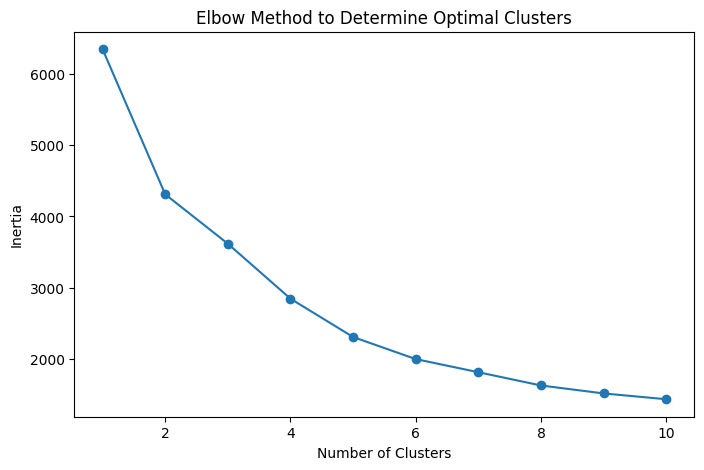

In [142]:
# Determine the optimal number of clusters using the Elbow Method
inertia = []
cluster_range = range(1, 11)
for k in cluster_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(features_scaled)
    inertia.append(kmeans.inertia_)

# Plot the Elbow Method
plt.figure(figsize=(8, 5))
plt.plot(cluster_range, inertia, marker='o')
plt.title('Elbow Method to Determine Optimal Clusters')
plt.xlabel('Number of Clusters')
plt.ylabel('Inertia')
plt.show()

In [143]:
# Perform KMeans Clustering with the optimal number of clusters (choose k from the elbow point)
k_optimal = 4  # Adjust based on the elbow point
kmeans = KMeans(n_clusters=k_optimal, random_state=42)
kmeans.fit(features_scaled)

# Add cluster labels to the original data
df_median['cluster'] = kmeans.labels_

# Analyze cluster centroids
centroids = pd.DataFrame(scaler.inverse_transform(kmeans.cluster_centers_), 
                         columns=features.columns)

In [144]:
centroids

,chs,churn,mub,pedidos,reativacao,restaurantes,renda_media,populacao,leads_total,restaurantes_reativados,restaurantes_churn,restaurantes_ativos
0,65.811667,7.872063,21797.396825,7.643221e+04,3.003373,446.265873,1283.559524,2.835944e+05,8613.198413,14.194444,38.876984,6.110317
1,69.233333,7.896667,477758.333333,1.578401e+06,3.543333,8041.666667,1960.666667,6.255238e+06,212674.000000,289.333333,701.000000,5.000000
2,8.573158,12.300526,766.368421,1.362632e+03,1.330000,18.842105,596.578947,5.616184e+04,796684.210526,0.052632,2.052632,0.000000
3,31.499098,10.498275,2975.329412,6.201698e+03,3.175804,71.129412,901.145098,1.039562e+05,2781.772549,1.964706,7.662745,2.831373


In [145]:
df_median.groupby('cluster').agg({'cidade':'count'})

,cidade
cluster,
0,251
1,3
2,19
3,256


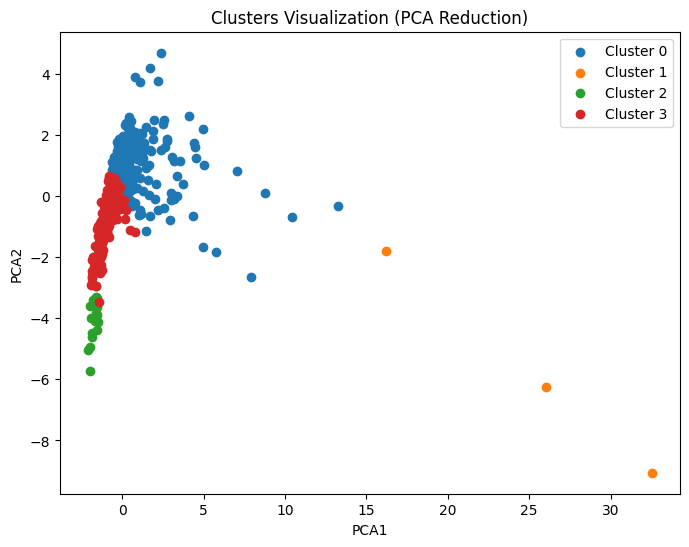

In [146]:
# Optional: Use PCA for dimensionality reduction to visualize clusters
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features_scaled)

# Add PCA components to the dataset for visualization
df_median['PCA1'] = features_pca[:, 0]
df_median['PCA2'] = features_pca[:, 1]

# Visualize clusters
plt.figure(figsize=(8, 6))
for cluster in range(k_optimal):
    cluster_data = df_median[df_median['cluster'] == cluster]
    plt.scatter(cluster_data['PCA1'], cluster_data['PCA2'], label=f'Cluster {cluster}')

plt.title('Clusters Visualization (PCA Reduction)')
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend()
plt.show()

    Correlation Matrix

In [147]:
df_num = df_median[['chs', 'churn', 'mub', 'pedidos',
                    'reativacao', 'restaurantes', 'renda_media', 'populacao', 'leads_total',
                    'restaurantes_reativados', 'restaurantes_churn', 'restaurantes_ativos']]

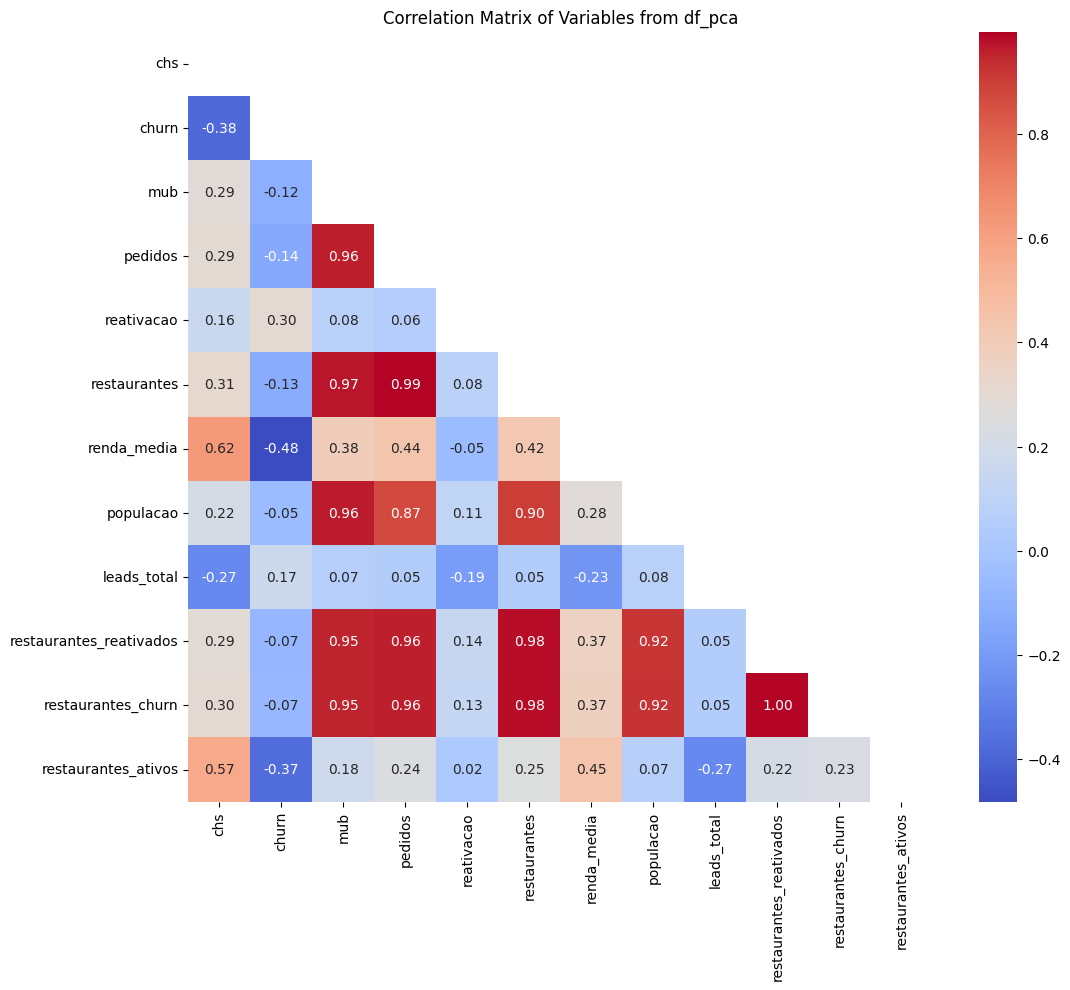

In [148]:
# Calculate the correlation matrix
corr_matrix = df_num.corr()

# Create a mask for the off-diagonal elements
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

# Plotting the correlation matrix heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", mask=mask)
plt.title('Correlation Matrix of Variables from df_pca')
plt.show()

Quanto maior a cobertura, menor o churn de restaurantes. Aparentemente uma maior cobertura populacional aumenta a competitividade.\
Um aumento no número de leads_total, tudo o mais constante, tem um impacto na cobertura chs. Aparentemente é indicios de economia saturada.\
___

    Boxplot of % de Restaurantes ativos per region of cluster 0

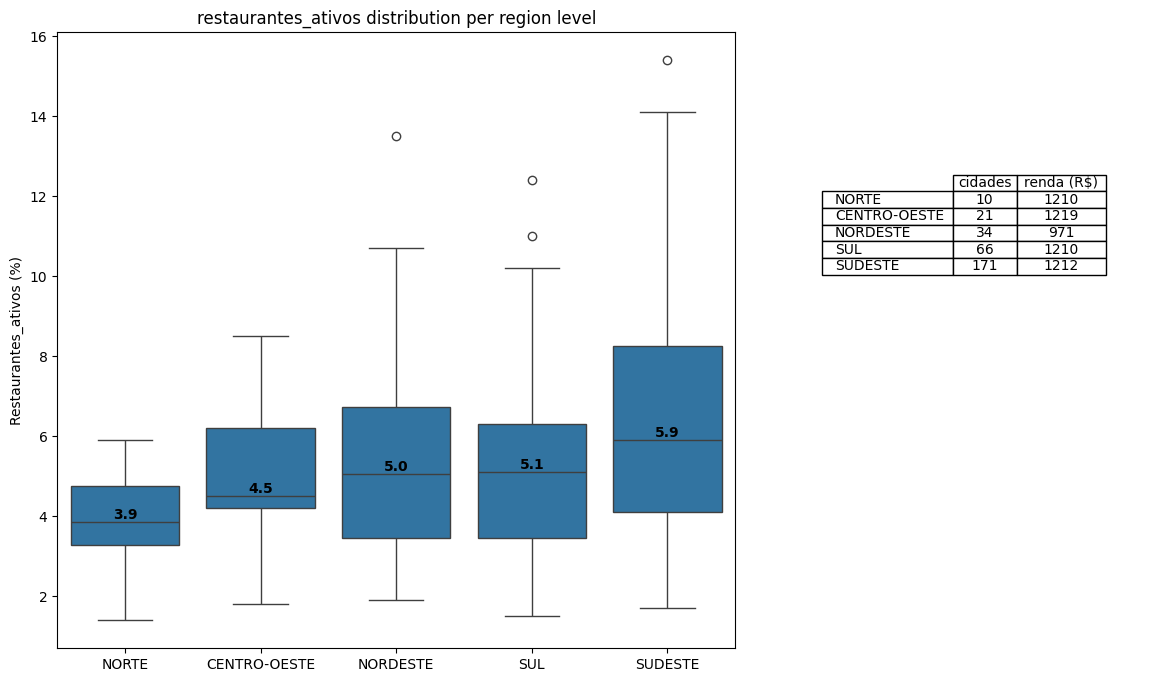

In [39]:
mf.boxplot_table(df=df_median, cluster=0)

Para o cluster 1 eu tenho 171 cidades no sudeste com mediana de restaurantes ativos.
___

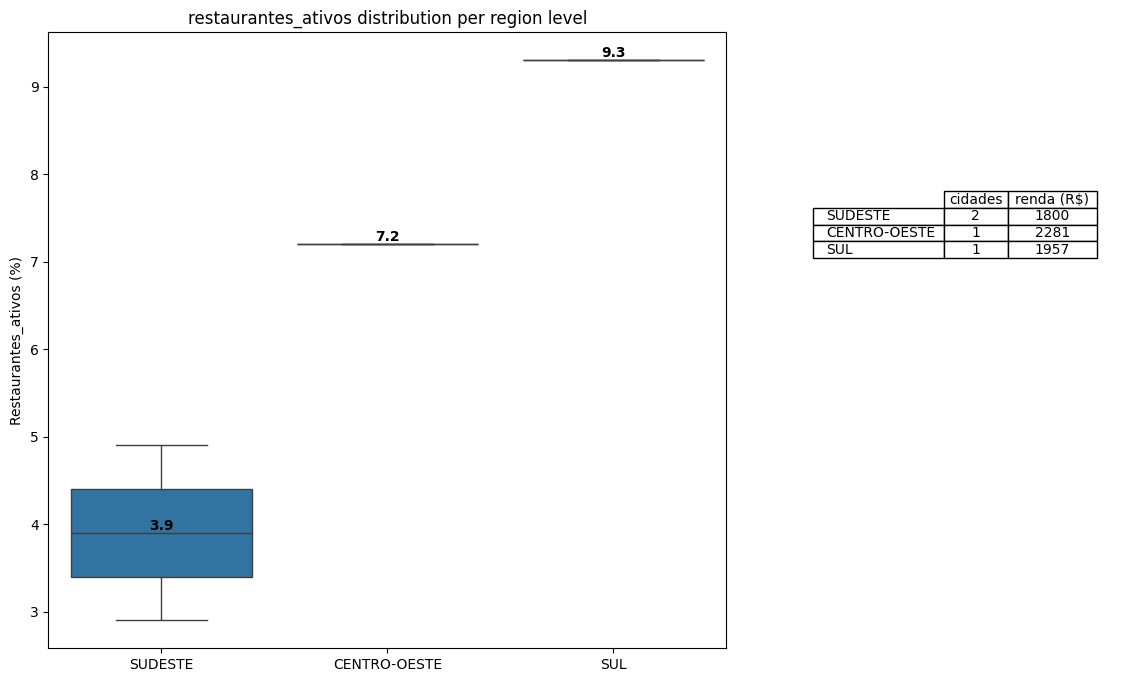

In [40]:
mf.boxplot_table(df=df_median, cluster=1)

Cluster 1 é o menos representativo em volumetria, representado por apenas 4 cidade de renda média alta.
___

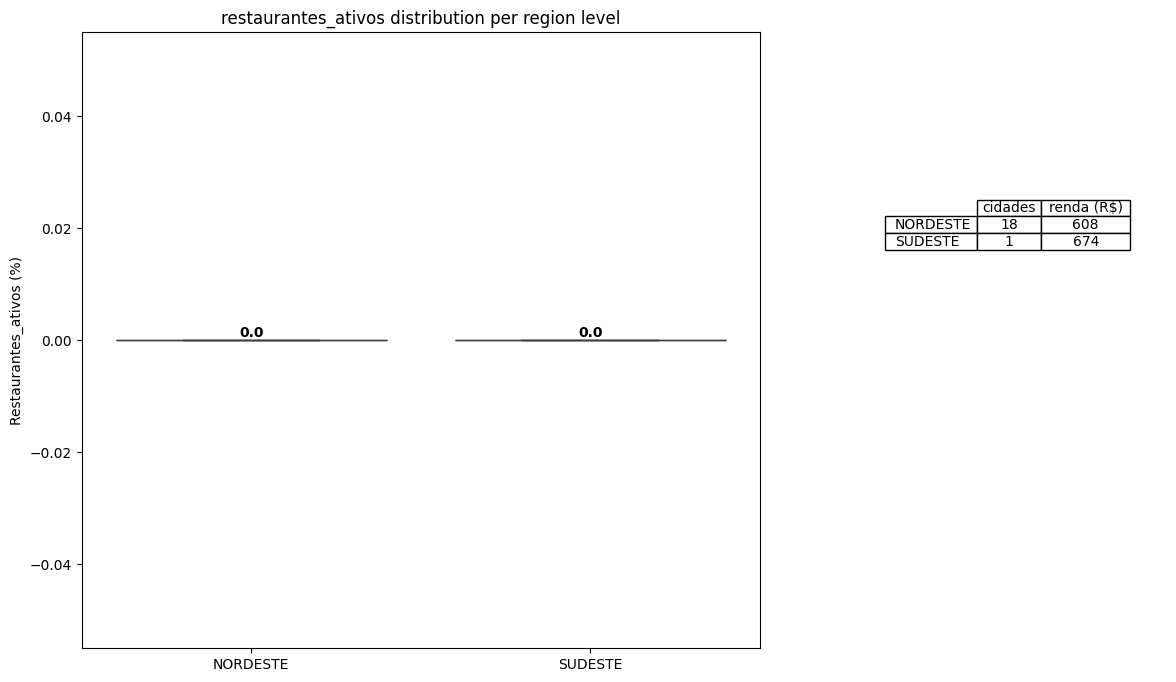

In [41]:
mf.boxplot_table(df=df_median, cluster=2)

Cluster 3 corresponde as cidades de menor renda, também tem o menor % de restaurantes ativos.\
Target: estimular o cadastro de restaurantes de baixo custo, utilizar cupom como incentivos para criar uma cultura de utilização da plataforma de delivery nessas regiões.
___

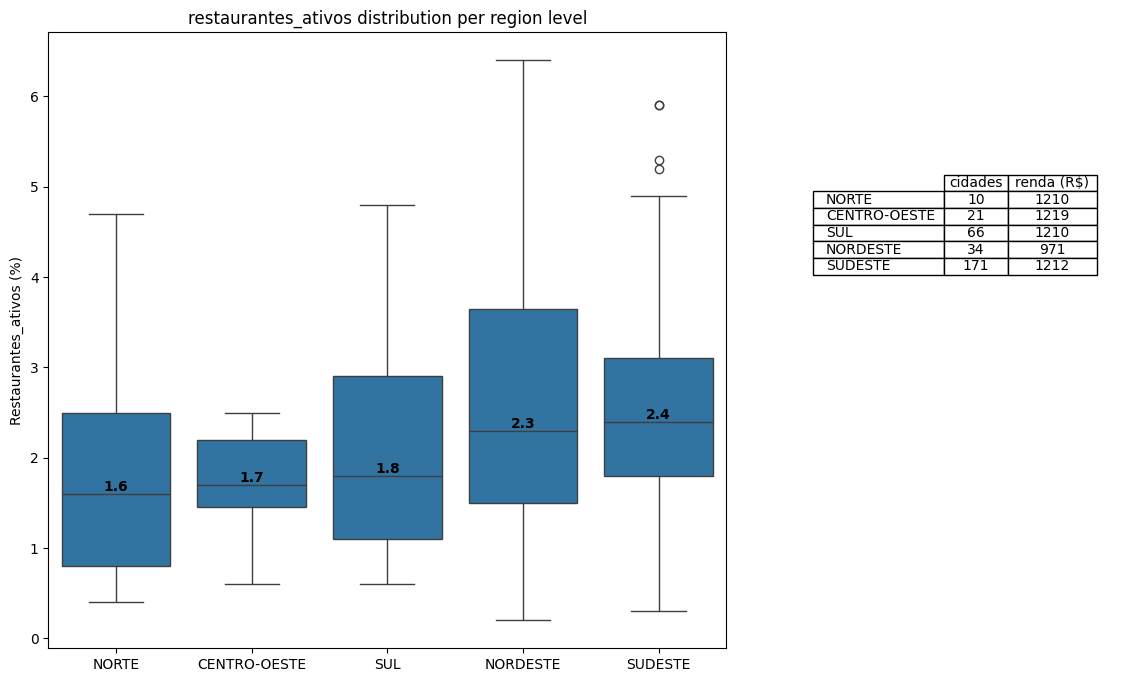

In [85]:
mf.boxplot_table(df=df_median, cluster=3)

Eu tenho cidades no nordeste, mais pobres, porém com um % de restaurantes ativos igual ao de cidades mais ricas do Sudeste. Norte, Centro-Oeste e Sul embora tenham o mesmo patamar de renda média, tem um % de restaurantes ativos abaixo da região Nordeste, que é a região de menor renda.\
TARGET: Elevar patamar de restaurantes ativos das Regiões Norte, Centro-Oeste e Sul. 
___

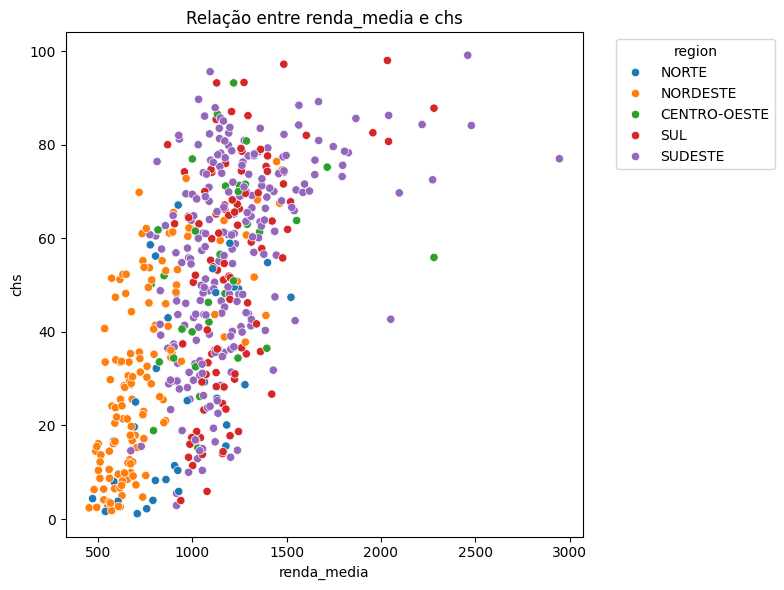

In [118]:
mf.plot_scatter(data=df_median, x='renda_media', y='chs', hue='region')

Algumas cidades do sudeste e do sul tem 2x a renda do nordeste, mas tem a mesma taxa de CHS. 
Target: Necessário esforço para aumentar restaurantes ativos nessa região e consequentemente elevar chs.